## ワインデータセットを用いた分類問題
3種類のワインのデータセットを用いてロジスティック回帰、SVM、決定木を用いて正解率を算出する
### 条件
- randam_stateは常に1とする
- 学習データとテストデータの比は7:3で固定する
- 学習に用いるラベルはカラム'target'を用いる
- 特徴量は13種類の中から1つ以上選択する
- 必要に応じて前処理を行う

### 各種依存関係をインポート

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### データセットインポート


In [10]:
wine_db = load_wine(as_frame=True)
wine_db.target[[10, 80, 140]]
print(wine_db.target_names)
print(wine_db.keys())
print(wine_db.frame)
print(wine_db.feature_names)

['class_0' 'class_1' 'class_2']
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13      

### ランダムフォレストによる特徴量毎の重要度を抽出
ランダムフォレストには ジニ不純度(Gini impurity)と呼ばれるノードごとに「ターゲットがどれくらい分類できていないか」を測る指標がある。

また、このジニ不純度を元に「ある特徴量で分割することでどれくらいジニ不純度を下げられるのか」を示す重要度という指標も存在するとわかった。
つまり、重要度は分類するために意味があるかの程度を特徴量ごとに相対的に示したものと解釈した。
この重要度を元に学習にかける特徴量を選定してみる。

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


重要度を示したところ、約10％台の数値が5つ存在した。
そのため、上位５つの特徴量を用いて学習と分類を行う。 
- 1) proline                        0.181655
- 2) flavanoids                     0.164055
- 3) alcohol                        0.146294
- 4) color_intensity                0.135429
- 5) od280/od315_of_diluted_wines   0.129824

In [11]:
# ランダムフォレストを用いた特徴量重要度の算出

scaler = StandardScaler()
scaled = scaler.fit_transform(wine_db.data)
forest = RandomForestClassifier(random_state=1)
forest.fit(scaled, wine_db.target)
importances = forest.feature_importances_

# 特徴量重要度の降順で特徴量名を表示
indices = np.argsort(importances)[::-1]
for f in range(wine_db.data.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, wine_db.feature_names[indices[f]], importances[indices[f]]))
    

    ### 結果出力用関数
def show_score(y_test, score, cm_name="confusion_matrix.png"):
    print("accuracy", accuracy_score(y_test, score))
    print("precision", precision_score(y_test, score, average='macro'))
    print("recall", recall_score(y_test, score, average='macro'))
    print("f1", f1_score(y_test, score, average='macro'))
    cm = confusion_matrix(y_test, score)
    print("confusion matrix", cm)
    
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.savefig(cm_name)
    plt.show()

    
# 重要度上位5つの特徴量を指定
x = wine_db.frame.iloc[:, [12, 6, 0, 9, 11]]
# 正規化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
y = wine_db.target

 1) proline                        0.181655
 2) flavanoids                     0.164055
 3) alcohol                        0.146294
 4) color_intensity                0.135429
 5) od280/od315_of_diluted_wines   0.129824
 6) hue                            0.082613
 7) total_phenols                  0.041013
 8) magnesium                      0.032354
 9) alcalinity_of_ash              0.022348
10) proanthocyanins                0.021885
11) malic_acid                     0.019838
12) ash                            0.012625
13) nonflavanoid_phenols           0.010068


#### 線形SVMによる分類
スコア結果は下記のようになった。

1件の誤分類を除いて、正しく推定できた。
元データセットには 13個の特徴量が存在するが、実質推定に必要なものは5個程度であるとわかった。
また、標準化の有無に関わらず各種メトリクスに違いはなかった。

##### 標準化なし
- accuracy 0.9814814814814815
- precision 0.9861111111111112
- recall 0.9824561403508771
- f1 0.9838987924094308

##### 標準化あり
- accuracy 0.9814814814814815
- precision 0.9861111111111112
- recall 0.9824561403508771
- f1 0.9838987924094308


accuracy 0.9814814814814815
precision 0.9861111111111112
recall 0.9824561403508771
f1 0.9838987924094308
confusion matrix [[23  0  0]
 [ 1 18  0]
 [ 0  0 12]]


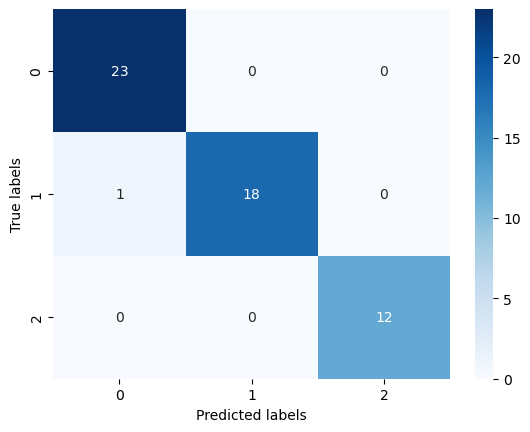

In [12]:
# 学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=1)

# SVM で学習する
svm_model = SVC(kernel='linear', C=1.0, random_state=1)
svm_model.fit(X_train, y_train)

score = svm_model.predict(X_test)

show_score(y_test, score, "svm_5_features_selected_by_random_forest_importance.png")

#### ロジスティック回帰による分類
スコア結果は下記のようになった。

ロジスティック回帰による分類でも線形SVM同様に1件の誤分類を除いて、正しく推定できた。
また、ロジスティック回帰の場合は 標準化をしないと学習が収束せずエラーとなることがわかった。

##### 標準化なし
学習が収束せずエラーとなる

```
/opt/conda/envs/winedb_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
```

##### 標準化あり
- accuracy 0.9814814814814815
- precision 0.9861111111111112
- recall 0.9824561403508771
- f1 0.9838987924094308


accuracy 0.9814814814814815
precision 0.9861111111111112
recall 0.9824561403508771
f1 0.9838987924094308
confusion matrix [[23  0  0]
 [ 1 18  0]
 [ 0  0 12]]


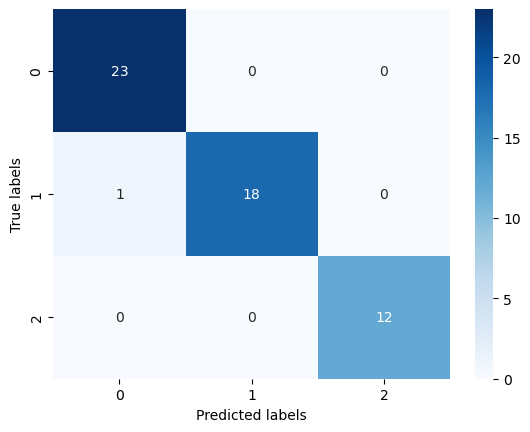

In [13]:
# 学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=1)

# SVM で学習する
logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_regression_model.fit(X_train, y_train)

score = logistic_regression_model.predict(X_test)

show_score(y_test, score, "log_5_features_selected_by_random_forest_importance.png")

### PCAによる特徴量の圧縮
PCAで13個の特徴量を低次元に圧縮する。
ランダムフォレストによる重要度の指標を目安として、PCAによる圧縮も5次元まで行ってみる。

In [14]:
scaler = StandardScaler()
scaled = scaler.fit_transform(wine_db.data)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(scaled)
y = wine_db.target

#### 線形SVMによる分類
スコアは下記のようになった。

テストデータすべてを正しく推定することができた。
ランダムフォレストの重要度から手動で学習する特徴量をピックアップするよりも、PCAのアルゴリズムに任せて次元を圧縮したほうが
結果的に精度が良いことがわかった。また、標準化したほうが精度向上が見込めることもわかった。


##### 標準化なし
- accuracy 0.9444444444444444
- precision 0.9521739130434783
- recall 0.940185608949911
- f1 0.9453734671125975

##### 標準化あり
- accuracy 1.0
- precision 1.0
- recall 1.0
- f1 1.0


accuracy 1.0
precision 1.0
recall 1.0
f1 1.0
confusion matrix [[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]


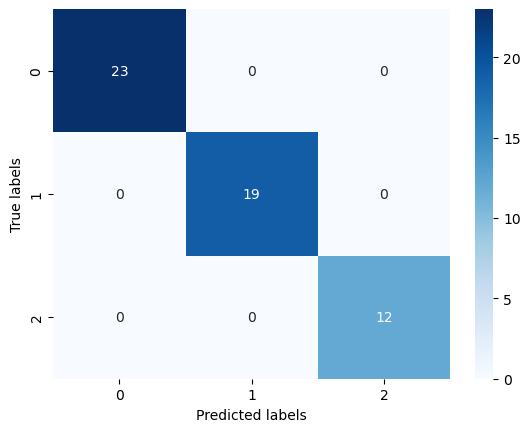

In [15]:
# 学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1)

# SVM で学習する
svm_model = SVC(kernel='linear', C=1.0, random_state=1)
svm_model.fit(X_train, y_train)

score = svm_model.predict(X_test)
show_score(y_test, score, "svm_5_features_decomposited_by_pca.png")

#### ロジスティック回帰
スコアは下記のようになった。

線形SVM同様テストデータすべてを正しく推定することができた。


##### 標準化なし
学習が収束せずエラーとなる

```
/opt/conda/envs/winedb_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
```

##### 標準化あり
- accuracy 1.0
- precision 1.0
- recall 1.0
- f1 1.0

accuracy 1.0
precision 1.0
recall 1.0
f1 1.0
confusion matrix [[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]


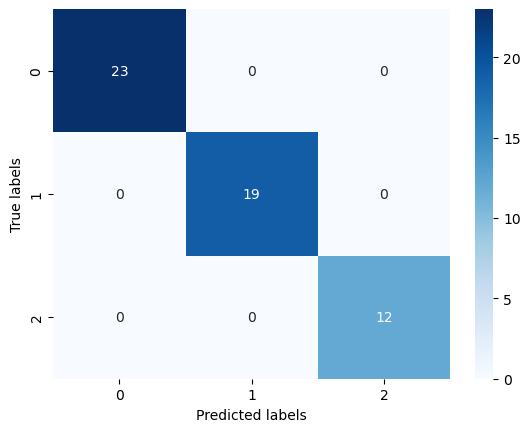

In [16]:
# 学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1)

# SVM で学習する
logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_regression_model.fit(X_train, y_train)

score = svm_model.predict(X_test)
show_score(y_test, score, "log_5_features_decomposited_by_pca.png")

### まとめ
ワインデータセットの分類問題を解いた。

特徴量を選定する方法として、ランダムフォレストによる重要度の大小によって学習する特徴量を選定する方法とPCAによる次元圧縮の方法の2種類を検証した。
また、学習・分類するモデルには線形SVMとロジスティック回帰の2種類を検証した。

特徴量選定方法と学習・分類毎の正解率を下記に示す。

|                 | ランダムフォレスト重要度(5次元)| PCA(5次元)  |
| --------------- | --------------------------| ----------- |
| ロジスティック回帰 | 0.98                      | 1.00        |
| SVM             | 0.98                      | 1.00        | 


検証結果より、PCAによって特徴量を5次元まで圧縮することによって正解率100%の精度を出すことができた。
今回の課題を通して、モデルの違いによって正解率が変化することはあまりなかったため、特徴量を選定する際の既存プラクティスの調査、学習にかける前の処理と分類精度の変化を検証していく作業がメインだった。
どのモデルを使用するかも重要だが、より高い分類精度を出力するためにはデータの前処理や特徴量の選定方法をトライ＆エラーすることも重要であると実感した。
